In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import time
import joblib
import rasterio
from rasterio.transform import from_origin
from PIL import Image
from scipy.ndimage import zoom

In [ ]:
# Load dataset
warnings.filterwarnings('ignore')
data = pd.read_csv('/content/drive/MyDrive/Train AI/dataset.csv')
data_non_null = data.dropna().reset_index(drop=True)

In [ ]:
#đổi timestamp tương ứng
timestamp = '2020-10-04 01:00:00'
filtered_df = data_non_null[data_non_null['timestamp'] == timestamp]
predict_filtered_df = filtered_df.copy()

In [ ]:
scaler = StandardScaler()
# Select numeric columns (for standardization)
numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

# Drop unwanted columns from the numeric columns
numeric_columns = numeric_columns.difference(['timestamp', 'col', 'row', 'aws-12', 'binary_label'])

# Fit and transform the training data
filtered_df[numeric_columns] = scaler.fit_transform(filtered_df[numeric_columns])

# print(filtered_df);

In [ ]:
#Load model da train bang joblib
loaded_model = joblib.load('/content/drive/My Drive/Train AI 2/xgboost_model_2.joblib')

In [ ]:
prediction = loaded_model.predict(filtered_df.drop(columns=['timestamp', 'col', 'row', 'aws', 'aws-12']))
label = filtered_df['aws']
# print("Label: " + str(label))
# print("Prediction: " + str(prediction))

In [ ]:
aws_index = numeric_columns.get_loc('aws')

target_mean = scaler.mean_[aws_index]
target_scale = scaler.scale_[aws_index]

# Destandardize y_test and y_pred
label = label * target_scale + target_mean
prediction = prediction * target_scale + target_mean

# print("Label: " + str(label))
# print("Prediction: " + str(prediction))

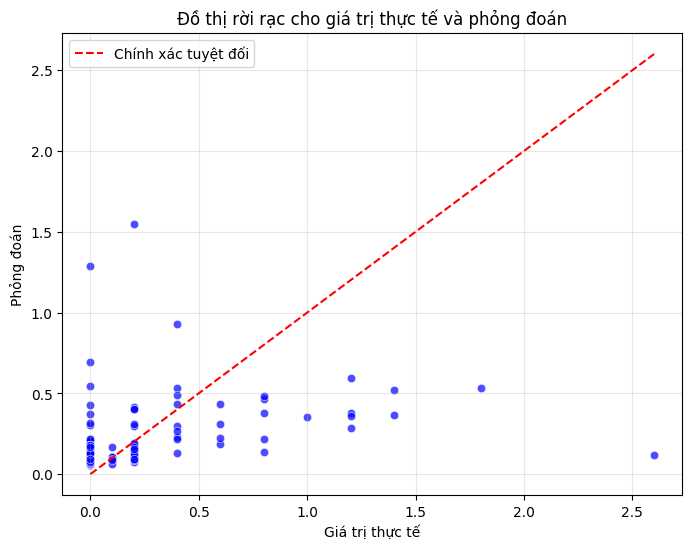

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=label, y=prediction, alpha=0.7, color='blue')

# Add a diagonal reference line for perfect correlation
max_val = max(label.max(), prediction.max())
min_val = min(label.min(), prediction.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Chính xác tuyệt đối')

# Customize the plot
plt.title('Đồ thị rời rạc cho giá trị thực tế và phỏng đoán')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Phỏng đoán')
plt.legend()
plt.grid(alpha=0.3)

# Save the plot to Google Drive
output_path = f'/content/drive/MyDrive/Train AI 2/{timestamp}/scatter_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save the plot with high resolution

plt.show();

plt.close()  # Close the plot to free memory

print(f"Scatter plot saved to {output_path}")

In [ ]:
# Modify prediction values close to 0.0
# prediction[prediction < 0.1] = 0.0
predict_filtered_df['aws'] = prediction
filtered_df['aws'] = label
# print(filtered_df)

In [ ]:
# # Prepare label (filtered_df['aws']) and prediction (predict_filtered_df['aws'])
for data, column, output_path in [
    (filtered_df, 'aws', f'/content/drive/MyDrive/Train AI 2/{timestamp}/label_image.tif'),
    (predict_filtered_df, 'aws', f'/content/drive/MyDrive/Train AI 2/{timestamp}/prediction_image.tif')
]:
    # Create a 2D array with the original data
    max_row = data['row'].max() + 1
    max_col = data['col'].max() + 1
    original_array = np.zeros((max_row, max_col), dtype=np.float32)
    for _, row in data.iterrows():
        original_array[row['row'], row['col']] = row[column]

    # Normalize the array to [0, 255] for better visualization
    min_val = original_array.min()
    max_val = original_array.max()
    normalized_array = ((original_array - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Save the image as a GeoTIFF
    transform = from_origin(0, 0, 1, 1)  # Placeholder transformation
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=normalized_array.shape[0],
        width=normalized_array.shape[1],
        count=1,
        dtype=normalized_array.dtype,
        transform=transform
    ) as dst:
        dst.write(normalized_array, 1)

    print(f"TIFF image created for {column}: {output_path}")

TIFF image created for aws: /content/drive/MyDrive/Train AI 2/2020-10-04 02:00:00/label_image.tif
TIFF image created for aws: /content/drive/MyDrive/Train AI 2/2020-10-04 02:00:00/prediction_image.tif


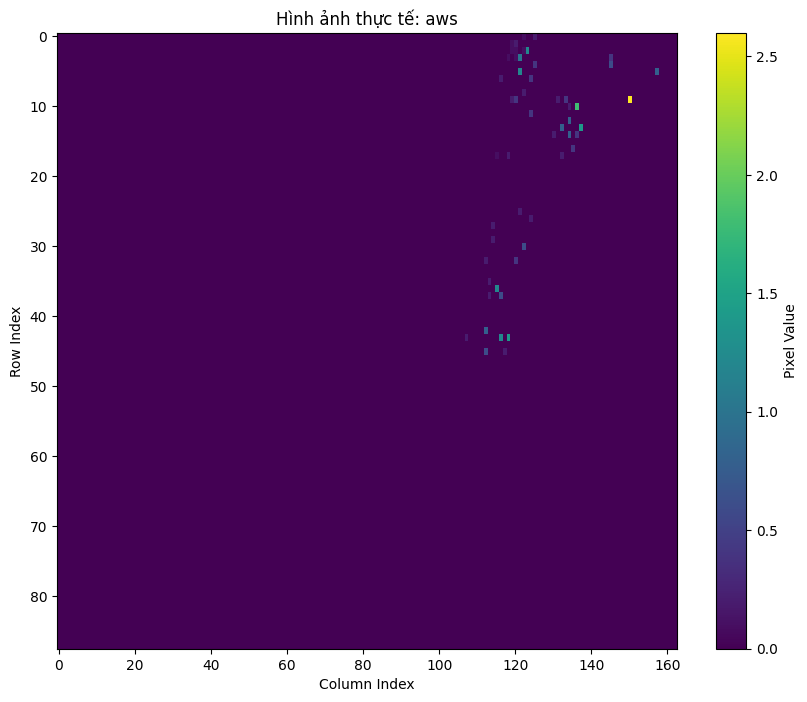

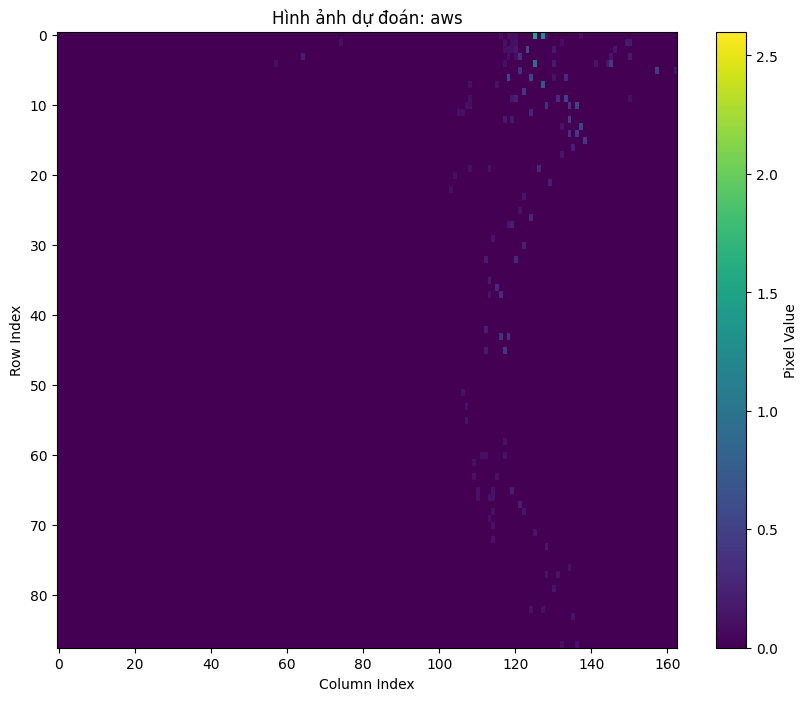

In [ ]:
# Calculate the global color range based on label data
label_min = filtered_df['aws'].min()
label_max = filtered_df['aws'].max()

# Prepare diagrams for label and prediction
for data, column, label in [
    (filtered_df, 'aws', 'Hình ảnh thực tế'),
    (predict_filtered_df, 'aws', 'Hình ảnh dự đoán')
]:
    # Create a 2D array with the original data
    max_row = data['row'].max() + 1
    max_col = data['col'].max() + 1
    original_array = np.zeros((max_row, max_col), dtype=np.float32)
    for _, row in data.iterrows():
        original_array[row['row'], row['col']] = row[column]

    # Create a plot (heatmap-like diagram)
    plt.figure(figsize=(10, 8))
    plt.imshow(
        original_array,
        cmap='viridis',      # Use a consistent colormap
        vmin=label_min,      # Set minimum value of color range
        vmax=label_max,      # Set maximum value of color range
        aspect='auto',       # Adjust aspect ratio for better visualization
        origin='upper'       # Place row 0 at the top
    )
    plt.colorbar(label='Pixel Value')  # Add a color bar
    plt.title(f"{label}: {column}")
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    output_path = f'/content/drive/MyDrive/Train AI 2/{timestamp}/{label}_{column}.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Diagram saved to: {output_path}")

    # Display the plot
    plt.show()

    plt.close()